# This notebook handles ingestion of stocks data to feature store

In [1]:
# to align client/server mlrun version
# !/User/align_mlrun.sh

In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-03-31 06:42:25,132 [info] created and saved project stocks


> <b> Steps </b>
>  * [Creating mlrun function that reads stocks from yfinance and returning record oriented json](#Creating-mlrun-function-that-reads-news-from-yfinance-and-returning-record-oriented-json)
>  * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
>  * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
>  * [Testing ingestion service](#Testing-ingestion-service)
>  * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta) 

In [3]:
# !pip install yfinance yahoo_fin

## Creating mlrun function that reads stocks from yfinance and returning record oriented json
Unlike any other feature-set serving graph (where the data is sent as an event to the graph) we collect the data from within the graph.<br>
the event sent to the graph specify real-time configuration.

In [4]:
#mlrun: start-code

import yahoo_fin.stock_info as si
import datetime
import yfinance as yf
import pandas as pd
import json
from storey import Event

def get_stocks(event):
    '''
    event: dict with the following keys:
    start_delta - start collecting the data days back
    end_delta - collect data untill days back
    interval - interval of collected stocks data
    n_stocks - how many stocks to collect
    '''
    # getting stock names
    tickers = si.tickers_sp500()[:event['n_stocks']]
    # time deltas to scrape data
    start = datetime.datetime.now()-datetime.timedelta(event['start_delta'])
    end = datetime.datetime.now()-datetime.timedelta(event['end_delta'])
    interval = event['interval']
    
    # collecting data from yfinance
    return_list = []
    for ticker in tickers:
        hist = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
        hist['ticker'] = ticker
        hist['ticker2onehot'] = ticker
        return_list.append(hist)
        
    # some data manipulations
    df = pd.concat(return_list).reset_index().drop(axis=1,columns=['Dividends','Stock Splits'])
    print(f"downloaded {len(tickers)} stocks data with size of {df.shape}")  
    df['Datetime']= df['Datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    
    return json.loads(df.to_json(orient='records'))

def gen_event_key(event): # since using nosql as target, each event must have its key - therefore this step is needed !
    return Event(event.body,key=event.body['ticker'])

#mlrun: end-code

## Creating a feature set and declaring the graph 

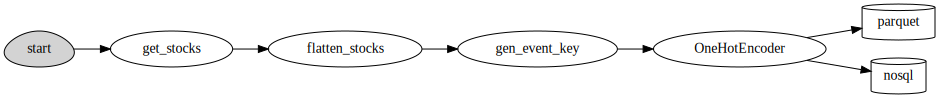

In [5]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, OneHotEncoder
import yahoo_fin.stock_info as si

info_set = fstore.FeatureSet("stocks_data", 
                             entities=[fstore.Entity("ticker")],
                             timestamp_key='Datetime', 
                             description="stocks feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
n_tickers = 4


info_set.graph\
        .to(name='get_stocks',handler='get_stocks')\
        .to("storey.steps.Flatten", name="flatten_stocks")\
        .to(name='gen_event_key',handler='gen_event_key',full_event=True)\
        .to(OneHotEncoder(mapping={'ticker2onehot':{ticker:str(idx) for idx,ticker in enumerate(si.tickers_sp500()[:n_tickers])}}))\
    
# Setting default targets (nosql & parquet)
info_set.set_targets(with_defaults=True) 
info_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [6]:
import os 
import datetime

# ingesting dummy (A MUST) 
name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(info_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'start_delta':7,
                                      'end_delta':3,
                                      'interval':'5m',
                                      'n_stocks':4}))

downloaded 4 stocks data with size of (628, 8)
downloaded 4 stocks data with size of (628, 8)


,Datetime,Open,High,Low,Close,Volume,ticker2onehot_A,ticker2onehot_AAL,ticker2onehot_AAP,ticker2onehot_AAPL
ticker,,,,,,,,,,
A,2022-03-31 06:42:49.022732+00:00,134.889999,135.240005,134.625000,134.748505,240669,1,0,0,0
A,2022-03-31 06:42:49.047660+00:00,134.490005,134.539993,134.119995,134.460007,8741,1,0,0,0
A,2022-03-31 06:42:49.048367+00:00,134.535004,134.535004,134.059998,134.100006,7449,1,0,0,0
A,2022-03-31 06:42:49.048598+00:00,133.940002,134.000000,133.750000,133.914993,5146,1,0,0,0
A,2022-03-31 06:42:49.048790+00:00,133.889999,134.350006,133.770004,134.024994,9238,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
AAPL,2022-03-31 06:42:49.170427+00:00,173.589996,173.928101,173.500000,173.759995,773587,0,0,0,1
AAPL,2022-03-31 06:42:49.170617+00:00,173.764999,174.255005,173.764999,174.220001,1019700,0,0,0,1
AAPL,2022-03-31 06:42:49.170807+00:00,174.220001,174.639999,174.210007,174.550003,1811239,0,0,0,1


In [7]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
info_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_stocks',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin', 'yfinance'])

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [8]:
# Deploying
info_set_endpoint = fstore.deploy_ingestion_service(featureset=info_set, run_config=run_config)

> 2022-03-31 06:42:55,041 [info] Starting remote function deploy
2022-03-31 06:42:55  (info) Deploying function
2022-03-31 06:42:55  (info) Building
2022-03-31 06:42:55  (info) Staging files and preparing base images
2022-03-31 06:42:55  (info) Building processor image
2022-03-31 06:42:58  (info) Build complete
2022-03-31 06:43:07  (info) Function deploy complete
> 2022-03-31 06:43:08,096 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-get-stocks.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-get-stocks-stocks-dani.default-tenant.app.app-lab-3-2-3.iguazio-cd1.com/']}


## Testing ingestion service

In [9]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(info_set_endpoint,json={'ticker':['stocks'],
                                                 'Datetime': now,
                                                 'start_delta':3,
                                                 'end_delta':0,
                                                 'interval':'5m',
                                                 'n_stocks':4})
t.text

'{"id": "ff8e5fbb-9698-41b2-aef4-a6dd3e55b64f"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [10]:
os.makedirs('src',exist_ok=True)

In [11]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['stocks'],
                                     'Datetime': now,
                                     'start_delta':1,
                                     'end_delta':0,
                                     'interval':'5m',
                                     'n_stocks':4})

Overwriting src/invoker.py


In [13]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_stocks',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':info_set_endpoint}, schedule='0 8 * * *')

> 2022-03-31 06:43:20,526 [info] starting run ingestion-service-stocks-ingestion_service_invoker uid=d1a203109acb4899b9c83f251c3cf782 DB=http://mlrun-api:8080
> 2022-03-31 06:43:20,812 [info] task scheduled, {'schedule': '0 8 * * *', 'project': 'stocks-dani', 'name': 'ingestion-service-stocks-ingestion_service_invoker'}
